<h3 align="left">Workflow</h3>

In this notebook, we repeat the processes done previously, but now we are using by far a larger dataset.

1) We utilize the *principal component analysis* for finding clusters.
2) We explore the explained variance ratios of the principal components in order to see how much of the variance of the original data can be explained by *n* principal components.
3) We develop a sampling method to determine the *n* most representative temperature profiles.

<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler
import time
from collections import defaultdict

<br>

<h3 align="left">Read in the data</h3>

In [363]:
def read_netCDF4_data(filename):
    with Dataset(filename) as rootgrp:
        print(rootgrp)
        longitude = rootgrp['longitude'][:]
        latitude = rootgrp['latitude'][:]
        level = rootgrp['level'][:]
        time = rootgrp['time'][:]
        temperature = rootgrp['t'][:][:][:][:]
    return longitude, latitude, level, time, temperature

In [364]:
longitude, latitude, level, time, temperature = read_netCDF4_data('/fmi/scratch/project_2004400/jamin_code/data/T_profile_2010_2020.nc')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-10-14 07:00:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data7/adaptor.mars.internal-1665730697.065383-17808-14-ce77431c-f506-461b-9645-fa31ff6f4e68.nc /cache/tmp/ce77431c-f506-461b-9645-fa31ff6f4e68-adaptor.mars.internal-1665730517.9997954-17808-24-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), level(19), time(132)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 level(level), int32 time(time), int16 t(time, level, latitude, longitude)
    groups: 


In [5]:
temperature.shape

(132, 19, 721, 1440)

In [14]:
def create_temperature_profiles(t):
    """
    This function creates temperature profiles such that
    each column represent one pressure level.
    For example, the first column has the temperatures associated
    with pressure level 1.
    
    parameters:
        t: a 4D tensor containing time, pressure level, latitude, longitude.
        
    returns:
        2D matrix where each column represents one pressure level.
    """
    i = 0
    T_profiles = np.zeros((t[:, 0, :, :].size, t[0, :, 0, 0].size), float)
    for day in range(0, len(time)):
        #print(day)
        for lat in range(0, len(latitude)):
            for lon in range(0, len(longitude)):
                T_profiles[i, :] = t[day, :, lat, lon][None, :]
                i += 1
    return T_profiles

In [15]:
temperature_profiles = create_temperature_profiles(temperature)

In [20]:
temperature_profiles.shape

(137047680, 19)

In [21]:
# Save the temperature profiles (it takes very long time to produce them)
data = np.save('temperature_profiles.npy', temperature_profiles)

- Here we save the temperature profiles so that we don't have to create them again, since it takes a long time to create them in the loop above.

In [2]:
# Load the data
T_profiles = np.load('temperature_profiles.npy')

In [3]:
T_profiles.shape

(137047680, 19)

<br>

<h3>A function to save netCDF4 files</h3>

In [25]:
def save_data(data, filename="PCA_sample_temperatures"):
    with Dataset(f"{filename}.nc", "w", format="NETCDF4") as nc:
        # Description
        nc.description = ''
        # Dimensions
        nc.createDimension("rows", None)
        nc.createDimension("columns", None)
        # Variables
        nc = nc.createVariable("data", "f8", ("rows", "columns"))
        # Attributes
        nc.longname = "sampled PCA temperature profiles"
        # Assigning values
        nc[:, :] = data

<br>

<h3 align="left">PCA</h3>

In [4]:
# Scale the data for numerical stability
scaler = StandardScaler()
scaled_T_profiles = scaler.fit_transform(T_profiles)

In [5]:
scaled_T_profiles.shape

(137047680, 19)

In [6]:
pca = PCA(n_components=None)
pca_results = pca.fit_transform(scaled_T_profiles)

- Here we perform the principal component analysis without reducing the dimensions of the data so that we can wee how much of the variance of the original data can be explained by **n** principal components.

In [7]:
pca_results.shape

(137047680, 19)

In [8]:
def var_explained_by_n_components(arr, n):
    """
    This function calculates how much of the variance of the original data
    can be explained by n principal components.
    
    parameters:
        arr: array containing the explained variances of the principal components.
        n: the number of principal components.
        
    returns:
        The amount of variance of the original data that can be explained
        by n principal components
    """
    explained_sigmasq = np.round(np.sum(arr[:n]), 3)
    print(f'{explained_sigmasq} of the variance can be explained by {n} principal components.')

In [9]:
explained_var = pca.explained_variance_ratio_
for i in range(1, 13):
    var_explained_by_n_components(explained_var, i)

0.555 of the variance can be explained by 1 principal components.
0.861 of the variance can be explained by 2 principal components.
0.949 of the variance can be explained by 3 principal components.
0.97 of the variance can be explained by 4 principal components.
0.986 of the variance can be explained by 5 principal components.
0.991 of the variance can be explained by 6 principal components.
0.995 of the variance can be explained by 7 principal components.
0.997 of the variance can be explained by 8 principal components.
0.998 of the variance can be explained by 9 principal components.
0.998 of the variance can be explained by 10 principal components.
0.999 of the variance can be explained by 11 principal components.
0.999 of the variance can be explained by 12 principal components.


<br>

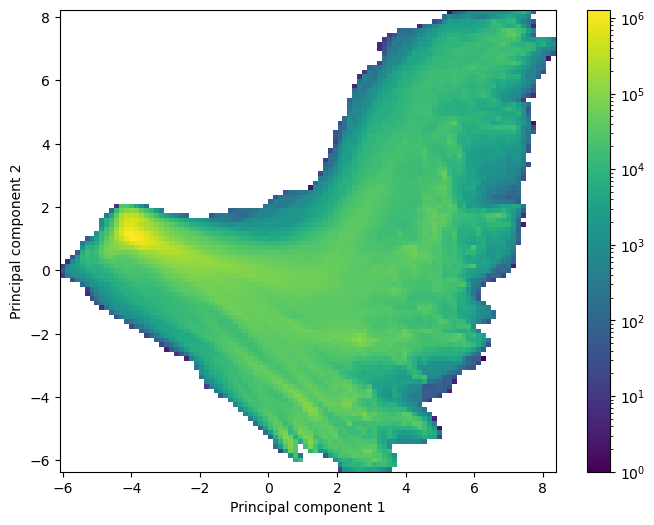

In [10]:
plt.figure(figsize=(8,6), dpi=100)
plt.hist2d(pca_results[:, 0], pca_results[:, 1], bins=100, norm=LogNorm())
plt.colorbar()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2');

<br>

<h3 align="left">Discretizing the data</h3>

In [12]:
def discretize_data(arr, bin_dims: list[int], n_components: int):
    """
    This function discretizes the given dataset into bins for each dimension of the data.
    
    Parameters:
        arr: a 2D dataset that is to be discretized.
        num_bins_per_dim: a list of bins you want to divide each dimension into.
        n_components: the number of principal components
        
    Examples:
        Suppose you want to use 5 principal components, and you want to discretize the first
        two principal component into 4 bins, the third principal component into 3 dims,
        and fourth and fifth principal components into 2 dims.
        The bin_dims argument would then be [4, 4, 3, 2, 2], and n_components would be 5.
    """
    # Take n principal components from the data
    data = arr[:, 0:n_components]
    
    # Initialize empty bins
    bins = []
    
    # Iterate over each dimension
    for i in range(len(bin_dims)):
        # Calculate bin edges for each dimension.
        edges = np.linspace(start=np.min(data[:, i]), 
                            stop=np.max(data[:, i] + 0.0001),
                            num=bin_dims[i] + 1)
        bins.append(edges)
        # Notice that if you have 3 bins, you need 3+1 edges: |-----|-----|-----|
        
    ##### Discretize each data point #####
    
    # Initialize an empty list to store the discretized data points
    discretized_data = []
    
    for point in data:
        # Initialize an empty array to store the discretized values 
        # for the current data point
        discrete_point = np.empty(data.shape[1], dtype=int)
        
        # Iterate through each dimension (column) of the current data point
        for j in range(data.shape[1]):
            # Find the bin index to which each element (dimension) in point[j] belongs to
            # (the np.digitize() function returns the index of the bin into which each element
            # in point[j] falls).
            # Notice that we subtract 1 from the bin indexes to convert it to 0-based indexing, 
            # which is a standard in Python (by default np.digitize() uses 1-based indexing).
            bin_index = np.digitize(point[j], bins[j]) - 1
            
            discrete_point[j] = bin_index
        discretized_data.append(discrete_point)
        
    # Convert the discretized data from a list into a numpy array
    discretized_data = np.array(discretized_data)
        
    # A function to count the number of occurrences of each bin index sequence
    def count_bin_idx_seqs(arr):
        # Initialize a dictionary to count the occurrences of each bin idx seq
        bin_idx_seq_count = defaultdict(int)
            
        # Iterate over each row, convert it to a tuple, and increase its count by 1.
        # Note that converting the rows (numpy arrays) into a tuple is necessary,
        # because numpy arrays are unhashable
        for seq in arr:
            seq_tuple = tuple(seq)
            bin_idx_seq_count[seq_tuple] += 1
                
        # Convert the defaultdict to a regular dict for a nicer output
        bin_idx_seq_count = dict(bin_idx_seq_count)
            
        return bin_idx_seq_count
            
    # Call the count_bin_idx_seqs() function on discretized_data to count the occurrences
    # of each bin index sequence
    counts = count_bin_idx_seqs(discretized_data)
        
    return discretized_data, counts, bins

<br>

In [15]:
def map_grids_to_temperatures(gridded_data, bins):
    """
    Function info here.
    
    Parameters:
        gridded_data: the discretized data that is returned from the gridding_data function
        bins: the bins that are returned from the gridding data function.
        
    Returns:
        info here.
    """
    # The number of principal components
    n = gridded_data.shape[1]
    
    # PCA
    pca = PCA(n_components=n)
    scaler = StandardScaler()
    scaled_temperature_profiles = scaler.fit_transform(T_profiles)
    pca_results = pca.fit_transform(scaled_temperature_profiles)
    
    points = np.zeros(shape=(len(gridded_data), n))
    for point_idx, point in enumerate(gridded_data):
        temp = np.zeros(shape=(n,))
        for idx, c in enumerate(point):
            val = (bins[idx][c] + bins[idx][c+1]) / 2
            temp[idx] = val
        points[point_idx, :] = temp
        
    # Inverse transform
    inversed_points = pca.inverse_transform(points)
    
    # Scale back to original temperatures
    original_temperatures = scaler.inverse_transform(inversed_points)
    
    return original_temperatures